*Library and Installation*

In [ ]:
%pip install unsloth
%pip install --upgrade --force-reinstall --no-cache-dir unsloth unsloth_zoo

*Initial Structure*

In [1]:
from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-10-20 14:24:59.695236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 14:24:59.703955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760970299.713520 4052463 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760970299.716764 4052463 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760970299.724864 4052463 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

INFO 10-20 14:25:01 [__init__.py:216] Automatically detected platform cuda.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
import os
import warnings
from typing import Any, Dict, List, Tuple, Union

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.model_selection import train_test_split

from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)

from trl import SFTTrainer
from unsloth import FastLanguageModel


# ---------------------------
# GPU INFORMATION
# ---------------------------
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major: {major_version}, Minor: {minor_version}")


# ---------------------------
# MODEL LIST
# ---------------------------
used_models = [
    "unsloth/Qwen3-0.6B-Base-unsloth-bnb-4bit",
    "unsloth/Qwen3-1.7B-Base-unsloth-bnb-4bit",
    "unsloth/Qwen3-4B-Base-unsloth-bnb-4bit",
    "unsloth/Qwen3-8B-Base-unsloth-bnb-4bit",
    "unsloth/Qwen3-14B-Base-unsloth-bnb-4bit",
]

NUM_CLASSES = 2
max_seq_length = 2048
dtype = None  # Auto detection


# ---------------------------
# MODEL SELECTION
# ---------------------------
model_name = "unsloth/Qwen3-14B-Base-unsloth-bnb-4bit"
load_in_4bit = True


# ---------------------------
# MODEL LOADING
# ---------------------------
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    load_in_4bit=load_in_4bit,
    max_seq_length=max_seq_length,
    dtype=dtype,
)

Major: 8, Minor: 9
==((====))==  Unsloth 2025.10.1: Fast Qwen3 patching. Transformers: 4.56.2. vLLM: 0.10.2.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 2. Max memory: 23.643 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
number_token_ids = []
for i in range(0, NUM_CLASSES+1):
    number_token_ids.append(tokenizer.encode(str(i), add_special_tokens=False)[0])
par = torch.nn.Parameter(model.lm_head.weight[number_token_ids, :])

old_shape = model.lm_head.weight.shape
old_size = old_shape[0]
print(par.shape)
print(old_shape)

model.lm_head.weight = par

reverse_map = {value: idx for idx, value in enumerate(number_token_ids)} # will be used later to convert an idx from the old tokenizer to the new lm_head
reverse_map

torch.Size([3, 5120])
torch.Size([151936, 5120])


{15: 0, 16: 1, 17: 2}

In [ ]:
from peft import LoftQConfig

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = [
        "lm_head", 
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, 
    bias = "none",    
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,  
)
print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.10.1 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM
trainable parameters: 64240640


*Data*

3030


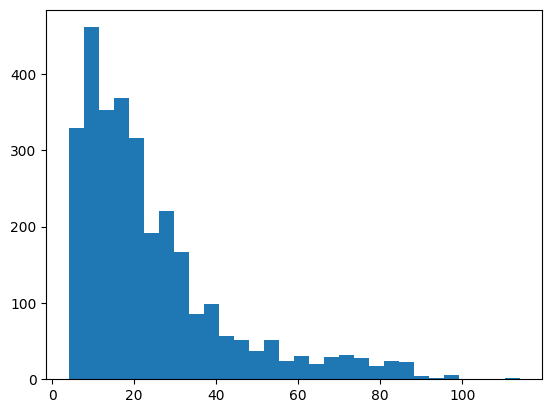

In [ ]:
data = pd.read_csv("/home/joaopedro/joaopedro/llm/Mestrado/Datasets/Boamente_Treino_Atualizado.csv") #columns are text,label

train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)
print(len(train_df))

token_counts = [len(tokenizer.encode(x)) for x in train_df.text]
a = plt.hist(token_counts, bins=30)

*Prompt and Data Collator*

In [ ]:
prompt = """Aqui está uma sentença.
{}

Se a sentença contém ideação suicida, responda "Sim". Caso contrário, responda "Não":

A resposta correta é: "{}"""

positivelabel = "Sim" #Yes
negativelabel = "Não" #No

def formatting_prompts_func(dataset_):
    texts = []
    for i in range(len(dataset_['text'])):
        text_ = dataset_['text'].iloc[i]
        label_ = dataset_['label'].iloc[i] #the csv is setup so that the label column corresponds exactly to the 3 classes defined above in the prompt (important)

        text = prompt.format(text_, label_)

        texts.append(text)
    return texts

#apply formatting_prompts_func to train_df
train_df['text'] = formatting_prompts_func(train_df)
train_dataset = datasets.Dataset.from_pandas(train_df,preserve_index=False)

In [ ]:
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
        self,
        *args,
        mlm: bool = False,
        ignore_index: int = -100,
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            batch["labels"][i, :last_token_idx] = self.ignore_index
            batch["labels"][i, last_token_idx] = reverse_map[ batch["labels"][i, last_token_idx].item() ]
        return batch
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

*Training with Cross-Validation*

In [ ]:
import torch
import numpy as np
from transformers import TrainingArguments
from trl import SFTTrainer
from sklearn.model_selection import StratifiedKFold
from datasets import Dataset

#Number of folds for cross-validation
num_folds = 5

#Convert the pandas dataset to the Hugging Face dataset format (if not already done)
full_dataset = Dataset.from_pandas(train_df, preserve_index=False)

#Create fold indices for cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=3407)

#Store metrics from each fold
all_results = []

#Iterate over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset["text"], full_dataset["label"])):
    print(f"\n🚀 Starting Fold {fold+1}/{num_folds}...")

    #Create training and validation subsets
    train_dataset = full_dataset.select(train_idx)
    val_dataset = full_dataset.select(val_idx)

    #Define training arguments
    training_args = TrainingArguments(
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,
        warmup_steps=10,
        learning_rate=1e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=3407,
        output_dir=f"outputs/fold_{fold+1}",  #Separate directory for each fold
        num_train_epochs=1,
        report_to="none",  #Disable logging to external services
        group_by_length=True,
    )

    #Create the Trainer
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,  #Adding validation
        max_seq_length=max_seq_length,
        dataset_num_proc=2,
        packing=False,
        args=training_args,
        formatting_func=formatting_prompts_func,
        data_collator=collator,
    )

    #Train the model
    trainer.train()

    #Evaluate the model on this fold's validation set
    metrics = trainer.evaluate()
    print(f"📊 Results for Fold {fold+1}: {metrics}")

    # Store the metrics
    all_results.append(metrics)

#Compute the mean metrics across all folds
final_results = {
    metric: np.mean([result[metric] for result in all_results]) for metric in all_results[0]
}

print("\n✅ Final average metrics after cross-validation:")
print(final_results)

#Note: the output is in Portuguese because it was the old version of the code. In the new version, the code and comments are in English.


🚀 Iniciando Fold 1/5...


Unsloth: Tokenizing ["text"] (num_proc=36):   0%|          | 0/2424 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=36):   0%|          | 0/606 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,424 | Num Epochs = 1 | Total steps = 38
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 1 x 1) = 64
 "-____-"     Trainable parameters = 64,240,640 of 14,054,650,880 (0.46% trained)


Step,Training Loss
1,1.419000
2,1.478200
3,1.592800
4,1.259300
5,0.942700
6,0.504800
7,1.156300
8,1.647900
9,1.799400
10,0.342100


Unsloth: Will smartly offload gradients to save VRAM!


📊 Resultados do Fold 1: {'eval_loss': 0.1452556848526001, 'eval_runtime': 10.1542, 'eval_samples_per_second': 59.68, 'eval_steps_per_second': 3.742, 'epoch': 1.0}

🚀 Iniciando Fold 2/5...


Unsloth: Tokenizing ["text"] (num_proc=36):   0%|          | 0/2424 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=36):   0%|          | 0/606 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,424 | Num Epochs = 1 | Total steps = 38
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 1 x 1) = 64
 "-____-"     Trainable parameters = 64,240,640 of 14,054,650,880 (0.46% trained)


Step,Training Loss
1,0.245900
2,0.030600
3,0.049700
4,0.134600
5,0.088400
6,0.343000
7,0.449200
8,0.220800
9,0.186500
10,0.021100


📊 Resultados do Fold 2: {'eval_loss': 0.12505994737148285, 'eval_runtime': 9.9383, 'eval_samples_per_second': 60.976, 'eval_steps_per_second': 3.824, 'epoch': 1.0}

🚀 Iniciando Fold 3/5...


Unsloth: Tokenizing ["text"] (num_proc=36):   0%|          | 0/2424 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=36):   0%|          | 0/606 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,424 | Num Epochs = 1 | Total steps = 38
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 1 x 1) = 64
 "-____-"     Trainable parameters = 64,240,640 of 14,054,650,880 (0.46% trained)


Step,Training Loss
1,0.111400
2,0.083300
3,0.157900
4,0.114000
5,0.191500
6,0.103400
7,0.109200
8,0.123500
9,0.033400
10,0.082400


📊 Resultados do Fold 3: {'eval_loss': 0.08966211974620819, 'eval_runtime': 9.9496, 'eval_samples_per_second': 60.907, 'eval_steps_per_second': 3.819, 'epoch': 1.0}

🚀 Iniciando Fold 4/5...


Unsloth: Tokenizing ["text"] (num_proc=36):   0%|          | 0/2424 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=36):   0%|          | 0/606 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,424 | Num Epochs = 1 | Total steps = 38
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 1 x 1) = 64
 "-____-"     Trainable parameters = 64,240,640 of 14,054,650,880 (0.46% trained)


Step,Training Loss
1,0.192800
2,0.015800
3,0.039800
4,0.027800
5,0.089300
6,0.089700
7,0.128000
8,0.056700
9,0.023300
10,0.088000


📊 Resultados do Fold 4: {'eval_loss': 0.0777270644903183, 'eval_runtime': 9.8821, 'eval_samples_per_second': 61.323, 'eval_steps_per_second': 3.845, 'epoch': 1.0}

🚀 Iniciando Fold 5/5...


Unsloth: Tokenizing ["text"] (num_proc=36):   0%|          | 0/2424 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=36):   0%|          | 0/606 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,424 | Num Epochs = 1 | Total steps = 38
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 1 x 1) = 64
 "-____-"     Trainable parameters = 64,240,640 of 14,054,650,880 (0.46% trained)


Step,Training Loss
1,0.015000
2,0.022800
3,0.083000
4,0.039800
5,0.085100
6,0.063500
7,0.141100
8,0.024900
9,0.084000
10,0.005600


📊 Resultados do Fold 5: {'eval_loss': 0.09026642888784409, 'eval_runtime': 10.0168, 'eval_samples_per_second': 60.499, 'eval_steps_per_second': 3.794, 'epoch': 1.0}

✅ Média final das métricas após validação cruzada:
{'eval_loss': np.float64(0.1055942490696907), 'eval_runtime': np.float64(9.9882), 'eval_samples_per_second': np.float64(60.677), 'eval_steps_per_second': np.float64(3.8048), 'epoch': np.float64(1.0)}


*Training with 80/20 (Hold-out)*

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False, 
    args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 10,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = 1,
        report_to = "none",
        group_by_length = True,
    ),
    data_collator=collator,
    dataset_text_field="text",
)

In [ ]:
trainer_stats = trainer.train()

*Inference*

In [ ]:
FastLanguageModel.for_inference(model) 
print()

*Evaluation with metrics*

In [10]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

#Define output directory
output_dir = "/home/joaopedro/joaopedro/llm/roc"
os.makedirs(output_dir, exist_ok=True)

#Load validation data
val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

#Define storage
all_probabilities = []
all_labels = []

#Step 1: Tokenization and sorting by token length
tokenized_inputs = []
for text, label in zip(val_texts, val_labels):
    test_str = prompt.format(text, "")
    tokenized_input = tokenizer(test_str, return_tensors="pt", add_special_tokens=False)
    tokenized_inputs.append((tokenized_input, test_str, label))

#Sort by tokenized length
tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

#Step 2: Group by tokenized length
grouped_inputs = defaultdict(list)
for tokenized_input, test_str, label in tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    grouped_inputs[length].append((tokenized_input, test_str, label))

#Step 3: Process batches
batch_size = 64

for length, group in tqdm(grouped_inputs.items()):
    for i in range(0, len(group), batch_size):
        batch = group[i:i + batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_labels = [item[2] for item in batch]

        #Concatenate batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        #Forward pass
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        #Extract logits for classification
        logits = outputs.logits[:, -1, :2]
        probabilities = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()  #Probability of class 1

        #Store results
        all_probabilities.extend(probabilities)
        all_labels.extend(batch_labels)

#Step 4: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

#Save ROC data
np.savetxt(os.path.join(output_dir, "fpr_Qwen3_14B.txt"), fpr)
np.savetxt(os.path.join(output_dir, "tpr_Qwen3_14B.txt"), tpr)
np.savetxt(os.path.join(output_dir, "thresholds_Qwen3_14B.txt"), thresholds)
with open(os.path.join(output_dir, "auc_Qwen3_14B.txt"), "w") as f:
    f.write(f"AUC: {roc_auc:.4f}\n")

#Step 5: Find optimal threshold
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

#Step 6: Convert probabilities to binary predictions
all_outputs = (all_probabilities >= optimal_threshold).astype(int)

#Step 7: Compute evaluation metrics
cm = confusion_matrix(all_labels, all_outputs)
accuracy = accuracy_score(all_labels, all_outputs)
precision = precision_score(all_labels, all_outputs)
recall = recall_score(all_labels, all_outputs)
f1 = f1_score(all_labels, all_outputs)

#Step 8: Save all metrics + confusion matrix to a single file
metrics_file = os.path.join(output_dir, "metrics_Qwen3_14B.txt")
with open(metrics_file, "w") as f:
    f.write("===== Model Evaluation Metrics =====\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n")
    f.write(f"AUC: {roc_auc:.4f}\n")
    
    f.write("\n===== Confusion Matrix =====\n")
    np.savetxt(f, cm, fmt="%d")

print(f"\nMetrics saved to: {metrics_file}")

#Step 9: Save confusion matrix separately
np.savetxt(os.path.join(output_dir, "confusion_matrix_Qwen3_14B.txt"), cm, fmt='%d')
print("\nConfusion Matrix:")
print(cm)
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

100%|██████████| 80/80 [00:13<00:00,  6.05it/s]

Optimal Threshold: 0.5622

Metrics saved to: /home/joaopedro/joaopedro/llm/roc/metrics_Qwen3_14B.txt

Confusion Matrix:
[[516  25]
 [ 15 202]]

Evaluation Metrics:
Accuracy: 0.9472
Precision: 0.8899
Recall: 0.9309
F1-Score: 0.9099
AUC: 0.9804
